### Week 1 - Properties of Time Series - Data, Filtering, Stationarity, ACF, PACF

### Packages, Importing Data

In [1]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.tsa.ar_model import AR
import math
from math import sqrt
from math import isnan
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### 1. Motivation

Generally, the motivation is forecasting and figuring out what might happen in the future, so you can make better decisions today.
*   Long-term: Climate Change (in 100 years)
*   Medium-term: Economic Forecasts (in 3-5 years)
*   Short-term: VaR (over 5 days), prices (15 minutes?)

What are the kind of possible sources from where a variable can be changed? 
1.    Change in its past value (AR component) e.g. AR. 
2.    Change in its determinants (DL component) e.g. ARMAX. 
3.    Occurance of some random event (MA component) e.g. MA. 
4.    Learning, detrioration or growth component (Trend).


### 2. Preliminary Steps: Looking at the Data and its Trend Properties

Before you do anything, you want to look at the data.

When doing so, you want to look at the properties of the data.

**Exanple: Australian macroeconomic data from Quarter 3 1969 - Quarter 1 2019**
*   Nominal GDP
*   Stock of money
*   Unemployment rate
*   CPI/prices
*   Short and long-term interest rates (3-month and 10-year Treasury bills)

Time series can differ in their trend behaviour. Nominal GDP and nominal money **smoothly** increase at **exponential rate**. 

Prices smoothly increase **linearly**. 

The unemployment rate increases in the **first half**, but decreases in the second half. In addition, in the first half, the **volatility is increasing**, then in the second half, the volatility is lower relative to the first.

Short and long-term interest rates have similar trends, where they are increasing in the first half and then a **large drop** and then **becomes relatively flat**. We also see that short-term interest rates are much more volatile than the long-term.

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
from pandas import datetime
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')
series = pd.read_csv('gdrive/My Drive/Colab Notebooks/Time Series/macro.csv', parse_dates = [0], date_parser = parser)
pd.options.display.float_format = '{:.2f}'.format
series.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Date,CONS,NGDP,MONEY,PRICE,SHORT,LONG,URATE,WAGE,INVEST
0,1969-07-01,53230000000.00,8845000000.00,14200000000.00,8.82,5.90,5.80,1.70,nan,18026000000.00
1,1969-10-01,53980000000.00,9061000000.00,14500000000.00,8.82,5.65,5.88,1.90,nan,18334000000.00
2,1970-01-01,54361000000.00,9285000000.00,14700000000.00,8.92,6.42,5.99,1.60,nan,18093000000.00
3,1970-04-01,54996000000.00,9642000000.00,15000000000.00,9.01,8.80,6.88,1.70,nan,18502000000.00
4,1970-07-01,55703000000.00,9705000000.00,15000000000.00,9.10,6.85,6.88,1.70,nan,18324000000.00


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


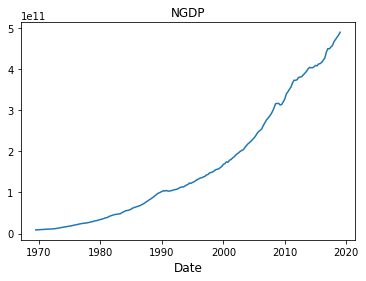

In [3]:
import matplotlib.pyplot as plt
plt.plot(series['Date'], series['NGDP'])
graph = plt.xlabel('Date', fontsize=12)
graph = plt.title('NGDP', fontsize=12)

### 3. Combining Series, Mean Stationarity and Cointegration

We can also **combine** and create additional series. For example, Real GDP is defined as the nominal GDP divided by the price level. 

We notice that Real GDP and NGDP both trend upwards, but NGDP appears to be relatively more smooth.

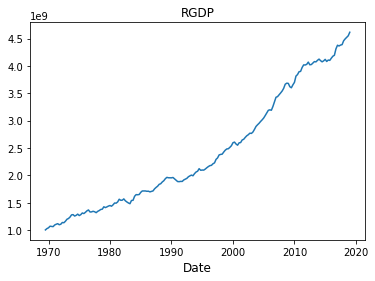

In [4]:
series['SPREAD'] = series['LONG'] - series['SHORT']
series['RGDP'] = series['NGDP']/series['PRICE']
plt.plot(series['Date'], series['RGDP'])
graph = plt.xlabel('Date', fontsize=12)
graph = plt.title('RGDP', fontsize=12)

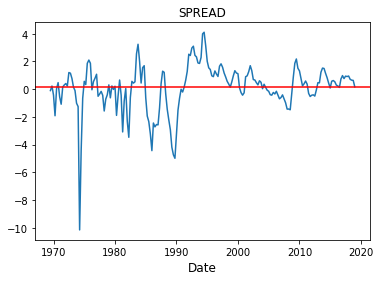

In [5]:
plt.plot(series['Date'], series['SPREAD'])
graph = plt.xlabel('Date', fontsize=12)
plt.axhline(y = series['SPREAD'].mean(), color = 'r', linestyle = '-')
graph = plt.title('SPREAD', fontsize=12)

Whilst the two individual series have trends, the spread is not trending. In other words, I can draw a horizontal line and say it hovers around or reverts back to this line. Formally, this series is **stationary in the mean**.

When you have two series that are non-stationary but the difference between them is stationary, that these series are **co-integrated**.



### 4. Methods to Achieve Stationarity: Combining and Filtering

We have **two ways** of obtaining series that are stationary from non-stationary series.


1.    We combine series and find co-integration
2.    We transform/filter out trends and changing volatility



### 5. Logarithmic Filters

Other than combining series, we can also **filter** or transform these series.

A common filter is the **logarithmic filter**, which is taking the natural log of a series. Why?
1.   Capture nonlinearities (turn non-linear trends into linear trends) i.e. If we can forecast the log of a variable, we can un-log it to forecast the variable itself!
2.   Correct for changing volatility (big movements are dampened more than smaller movements)

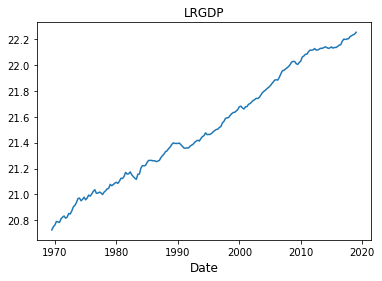

In [6]:
GDP = pd.DataFrame()
GDP['LRGDP'] = np.log(series['RGDP']) #Logging negative values is undefined
plt.plot(series['Date'], GDP['LRGDP'])
graph = plt.xlabel('Date', fontsize=12)
graph = plt.title('LRGDP', fontsize=12)

### 6. First and Second Difference Filters

A second important filter is the **first difference filter**, which takes the difference in the current and previous (past) value i.e. look at the change in the variable. 
>$\Delta y_t=y_t - y_{t-1}$

Why? We can now account for and remove trends, so that we can obtain stationarity in the mean.




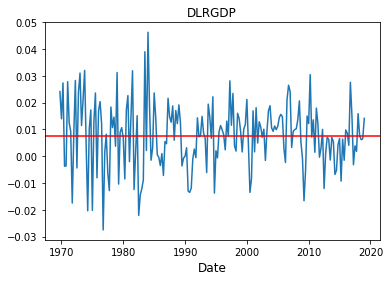

In [7]:
GDP['DLRGDP'] = GDP['LRGDP'].diff()
plt.plot(series['Date'], GDP['DLRGDP'])
graph = plt.xlabel('Date', fontsize=12)
plt.axhline(y = GDP['DLRGDP'].mean(), color = 'r', linestyle = '-')
graph = plt.title('DLRGDP', fontsize=12)

There are additional differencing filters e.g. **second difference filter** i.e. first difference of the first difference, can be performed in one step:

>$\Delta^2 y_t=\Delta y_t - \Delta y_{t-1}$
>$=y_t -2y_{t-1} + y_{t+2}$

Why second differencing? A lot of nominal macroeconomic data such as nominal price, wages, GDP, money, etc. generally requires differencing twice to achieve stationarity.

### 7. Seasonal Difference Filters

You can also do **seasonal difference filters**. Seasonality is when a variable is relatively high/low at certain times e.g. certain quarters of months. To account for his, you calculate the difference between the same month in different years for example.

If you had quarterly data, annual changes would involve difference the same quarter last year:
>$y_t - y_{t-4}$

If you had monthly data, you would do:
>$y_t - y_{t-12}$

Suppose you wanted to compute a weekly change with daily data would involve:
>$y_t - y_{t-5}$

### 8. Moving Average (MA) Filters

There are also **Moving Average filters**. This has an effect of smoothing fluctuations in the data.

Third order MA filter averages 3 observations:
>$MA(3) = (y_t + y_{t-1} + y_{t-2})/3$

Fifth order MA filter averages 5 observations:
>$MA(5) = (y_t + y_{t-1} + y_{t-2} + y_{t-3} + y_{t-4})/5$

Moving averages are often **centered**.
>$MA(3) = (y_{t+1} + y_{t} + y_{t-1})/3$



### 9. Power Filters

The **square filter** is used to **detect changes in volatility** in financial markets because you go from mean to variance analysis:
>$x_t = y^2_t$

The **cubic filter** is used to detect changes in **skewness** over time:
>$x_t = y^3_t$

The **quartic filter** is used to detect changes in **kurtosis** over time:
>$x_t = y^4_t$


### Filter Examples

In [8]:
spread = pd.DataFrame()
#First-difference filter
spread['DSPREAD'] = series['SPREAD'].diff()
#Second-difference filter
spread['D2SPREAD'] = spread['DSPREAD'].diff()
#Seasonal-difference filter (annual change)
spread['SPREAD_SEASONAL'] = series['SPREAD'][4:] - series['SPREAD'][:-4]
#3rd order moving average (MA) filter
spread['SPREAD_MA3'] = (series['SPREAD'][2:] + series['SPREAD'][1:-1] + series['SPREAD'][:-2])/3
#Square filter (volatility)
spread['SPREAD_P2'] = (series['SPREAD'])**2
#Cubic filter (skewness)
spread['SPREAD_P3'] = (series['SPREAD'])**3
#Quartic filter (kurtosis)
spread['SPREAD_P4'] = (series['SPREAD'])**4
#Squared demeaned filter
spread['SPREAD2'] = (series['SPREAD'] - series['SPREAD'].mean())**2
#Absolute demeaned filter
spread['SPREAD_ABS'] = abs(series['SPREAD'] - series['SPREAD'].mean())
#2-period moving sum filter
spread['SPREAD3'] = series['SPREAD'][1:] + series['SPREAD'][:-1]
#Log filter
spread['LSPREAD'] = np.log(series['SPREAD']) #Logging negative values is undefined

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


### 10. Lag Operators

We define L as the lag operator. A convenient way to represent filters and combining filters.

1 lag:
>$y_{t-1} = Ly_t$

2 lags:
>$y_{t-2} = L^2y_t$

k lags:
>$y_{t-k} = L^ky_t$

Thus, a first difference filter using lag operators is:
>$y_t - y_{t-1} = y_t - Ly_t = (1-L)y_t$

It is also possible to have future values represented, using negative values of k:
>$y_{t+k} = L^{-k}y_t$

Useful for centered MA(3) filters for example.

### 11. Stationarity and Methods to Identify Stationarity

(Covariance) Stationarity is an important concept in time series analysis. 

3 ways to identify stationarity:
1.   Graphical 

*   If the series **reverts around a horizontal line**, it is **stationary in the mean**, if the series' **volatility is constant over time**, it is **stationary in the variance**
*   If it trends up or downwards, not stationary
*   If volatility increases or decreases over the sample, not stationary



2.   Statistical 
*   If the **unconditional moments** i.e. mean, variance (specific case) and autocovariances (general case) are **not a function of time**
*   $\mu = E(y_t)\neq f(t)$
*   $\gamma_0 = E(y_t - \mu)^2\neq f(t)$
*   $\gamma_k = E(y_t - \mu)(y_{t-k}-\mu)\neq f(t)$
3.   Impulse Analysis

*   We check if a shock in the series eventually dies out 
*   Consider the AR(1) model: $y_t = \phi_0 + \phi_1 y_{t-1} + u_t$
*   The effect pf a shock $u_t$ on $y_t$ is 1-to-1 i.e. If the shock is equal to positive 1, this increases $y_t$ by 1
*    In the next period, $y_{t+1} = \phi_0 + \phi_1 y_{t} + u_{t+1}$, this tells us that the effect of $u_t$ on $y_{t+1}$ is $\phi_1$
*    We should expect that $\phi_0 < 1$ where it has a **diminishing effect** on $y_t$ if it is **stationary**

We typically look at covariance stationarity (first 2 moments are stationary). Strict stationary if all of the momennts are stationary. 

If a series is normally distributed, then it is strictly stationary if it is covariance stationary (because the distribution is defined by only 2 moments). 

Nonstationarity means if one of the moments (mean or variance) are functions of time.

**Why do we care about having stationarity?** We want to know what a variable's expected value, variance and correlation between other variable in different periods. 
We calculate this using a mean across many time periods - but this is only informative if the expected value is the same across those time periods. If everything is different in the past, then its impossible to forecast tomorrow. But if we find something that is the same in the past, then we may know that its the same in the future.

Stationarity requires a finite and time-invariant mean, variance and covariance. Non-stationarities can come from deterministic changes (like trend, seasonality/cycles) or stochastic properties (like unit root). Non-stationarity data as a rule are unpredictable and cannot be modeled or forecasted. Results obtained by using non-stationary time seires may be spurious/useless. Hence, non-stationary data may need to be transformed into stationary data through filtering methods.

A unit root implies non-stationarity (even if the process is stationarity in the mean). This is because the moments of the process depend on time and are thus time-varying. For example, if we have an AR(1) process where we have a unit root, the variance of the process at 't' is equal to the unconditional variance multiplied by 't'. Note that the variance of the series is diverging to infinity with 't'.

How to identify non-stationarity? 1. Deterministic trends can be identified visually and can be taken into account using detrending it (-beta times t).

1. Graphical: Is there a trend? Do you see if variances are different in different periods? Check the random subperiod tests. 2. Check if there is no unit root (1 type of non-stationarity). 3. Check KPSS test for evidence against stationarity. 4. Check ACF rapid decay. Make overall weighted average conclusions.


### 12. Autocorrelation Function (ACF) and Statistically Testing for ith Order Autocorrelation 

The ACF computes the correlation between a variable itself $p$ lags ago.

Done by running the regression (OLS):
$y_t = \phi_0 +\phi_1 y_{t-i} +u_t$

Where $u_t$ is the error term, normally distributed $u_t \sim N(0,\sigma^2_u)$

We obtain the sample autocorrelation estimate $\hat  \phi_i $

The ACF runs the regression for 1 lag, 2 lags, 3 lags,... and collects the correlations ($\phi_i$ parameters) and plots it against each lag. 

We would want to test if the coefficients are statistically significant. 
*   Null: $H_0:\phi_i = 0$
*   Alternative: $H_0: \phi_i \ne 0$

The sample autocorrelations are distributed asymptotically as $\hat  \phi_i \sim N(0,1/T)$ where $T$ is the sample size.

The test statistic is thus:

$\sqrt{T} \hat  \phi_i \sim N(0,1)$

At the 5% level, the critical value is 1.96 (p-value is 0.05). If the test statistic is greater than 1.96 (p-value is less than 0.05) than we reject the null at the 5% level and choose the alternative hypothesis.

In regards to the ACF, a **stationary process should exhibit a rapidly decaying ACF**. We may see if a series is non-stationary if it does not converge to 0 or if it does not converge at a 'rapid enough' rate.



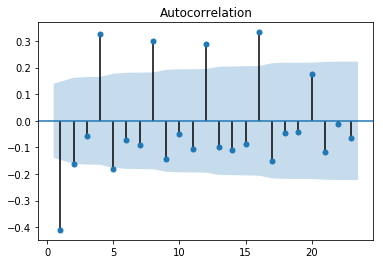

In [9]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
variable = spread['D2SPREAD']
acfplot = plot_acf(variable[pd.Series.first_valid_index(variable):], alpha = .05, zero = False)

In [10]:
acfresults = acf(variable[pd.Series.first_valid_index(variable):], nlags = 30, qstat = True, alpha = .05)
pacfresults = pacf(variable[pd.Series.first_valid_index(variable):], nlags = 30, method = 'ols', alpha = .05)
correlogram = pd.DataFrame(columns = ['Lag','AC', 'PAC', 'Q-Statistic', 'P-Value'])
np.set_printoptions(precision=3, suppress=True)
correlogram['Lag'] = range(1, 31)
correlogram['AC'] = acfresults[0][1:]
correlogram['PAC'] = pacfresults[0][1:]
correlogram['Q-Statistic'] = acfresults[2]
correlogram['P-Value'] = acfresults[3]
pd.options.display.float_format = '{:.4f}'.format
print("Critical value ACF 5% level: {:.4f}".format(1.96/(len(variable))**0.5))
correlogram.head()

Critical value ACF 5% level: 0.1389


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


,Lag,AC,PAC,Q-Statistic,P-Value
0,1,-0.4099,-0.4101,33.6129,0.0000
1,2,-0.1632,-0.3997,38.9676,0.0000
2,3,-0.0557,-0.4431,39.5947,0.0000
3,4,0.3245,-0.0081,60.9845,0.0000
4,5,-0.1809,-0.0891,67.6693,0.0000


### 13. Partial Autocorrelation Function (PACF) and Partial Autocorrelation Test

The PACF computes the correlation between a variable itself $p$ lags ago, **given that intermediate lags are included**.

Done by running the regression (OLS):
$y_t = \phi_0 +\phi_{1i} y_{t-1} + \phi_{2i} y_{t-2} + ... + \phi_{pi} y_{t-p}  +u_t$

Where $u_t$ is the error term, normally distributed $u_t \sim N(0,\sigma^2_u)$

We obtain the sample autocorrelation estimate $\hat  \phi_{ii} $

The ACF runs the regression for 1 lag, 2 lags, 3 lags,... and collects the correlations ($\phi_{ii}$ parameters) and plots it against each lag. 

We would want to test if the coefficients are statistically significant. 
*   Null: $H_0:\phi_{ii} = 0$
*   Alternative: $H_0: \phi_{ii} \ne 0$

The sample autocorrelations are distributed asymptotically (the same as ACF regression) as $\hat  \phi_i \sim N(0,1/T)$ where $T$ is the sample size.

The test statistic is thus:

$\sqrt{T} \hat  \phi_i \sim N(0,1)$

At the 5% level, the critical value is 1.96 (p-value is 0.05). If the test statistic is greater than 1.96 (p-value is less than 0.05) than we reject the null at the 5% level and choose the alternative hypothesis.

A PACF is good for telling us what order AR process may best fit the series.

We think of ACF and PACF as **prelimary checks** of the series before thinking about modelling.

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


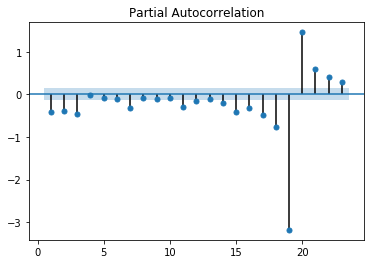

In [11]:
pacfplot = plot_pacf(variable[pd.Series.first_valid_index(variable):], alpha = .05, zero = False)

### 14. Slutsky Effect and Long Swing Hypothesis

Long Swing Hypothesis: A lot of economic variables seem to exhibited a very long cycle (of 20 years), identified by applying 2 filters (5-year MA and 5-year centered first difference). The lessons are to be **weary of MA filters**. Expanding the lag operators, we see that the effective filter is a restricted centered **15-year MA filter**. 

The issue is that a (random) white noise process (simulated from N(0,1)) after applying this filter appears to have **strong evidence of cycles!**  

ACF and PACF: Original series both have flat results. We see cyclical results in ACF and significant spikes in PACF. i.e. Cycles were generated from the filters he used. 

### Week 2 - Autoregressive (AR) Models - Specification, Estimation, Model Properties, Forecasting (Ex-Ante and Post)

### 1. Autoregressive (AR) Models and Specification

An autoregressive (AR) model means our explanatory variables are lags of the dependent variable. Motivation? If we believe a variables past values can tell us what values it will have in the future.

i.e. $y_t = \phi_0 + \phi_1 y_{t-1} + u_t$.

The disturbance term $u_t$ in the AR(1) model is assumed to have zero mean, constant variance (homoskedascity) and zero autocovariance. Also called a white noise process.

If there is no 1st order autocorrelation i.e. $\phi_1 = 0$, then the model is effectively a white noise process, where all of the randomness comes from this term.

An AR(2) model is regressed by itself 1 period before and 2 periods before. Thus, an AR(p) model more generally speaking allows for p lags.

**Example: Unemployment Rate**. We will look at the data and then define its 1 period lag and show them side by side. Note that the first observation is missing because of the shift, which means when we do regressions, we have 1 less sample in our sample size i.e. $T - 1$

In [12]:
unemployment = pd.DataFrame()
unemployment['Date'] = series['Date']
unemployment['URATE'] = series['URATE']
unemployment['URATE(-1)']= unemployment['URATE'].shift(1)
unemployment.head()

,Date,URATE,URATE(-1)
0,1969-07-01,1.7000,nan
1,1969-10-01,1.9000,1.7000
2,1970-01-01,1.6000,1.9000
3,1970-04-01,1.7000,1.6000
4,1970-07-01,1.7000,1.7000


In [13]:
unemployment.tail()

,Date,URATE,URATE(-1)
194,2018-01-01,5.5188,5.4639
195,2018-04-01,5.4149,5.5188
196,2018-07-01,5.1902,5.4149
197,2018-10-01,5.0355,5.1902
198,2019-01-01,5.0187,5.0355


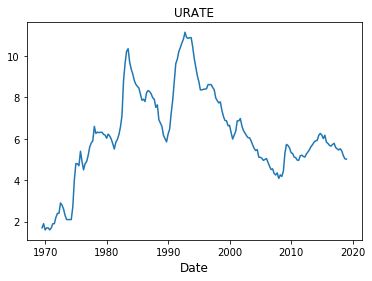

In [14]:
plt.plot(series['Date'], unemployment['URATE'])
graph = plt.xlabel('Date', fontsize=12)
graph = plt.title('URATE', fontsize=12)

###2. White Noise Properties

The disturbance term u_t in the AR(1) model is assumed to have zero mean, constant variance (homoskedascity) and zero autocovariance. White noise properties formally written as:

$E(u_t) = 0$

$E(u^2_t) = \sigma^2_u$

$E(u_t u_{t-s}) = 0, s \ne 0$

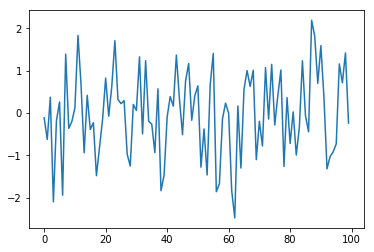

In [15]:
#White noise process
mean = 0
std = 1 
num_samples = 100
whitenoise = np.random.normal(mean, std, size=num_samples)
plt.plot(whitenoise)
plt.show()

Because the residuals are white noise, which have all autocvariances as zero, the ACF and PACF should not exhibit any significant autocorrelations and partial autocorrelations. We should check if our model residuals has white noise process.

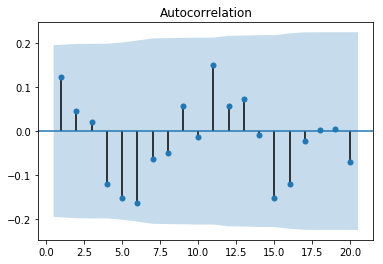

In [16]:
acfplot = plot_acf(whitenoise, alpha = .05, zero = False)

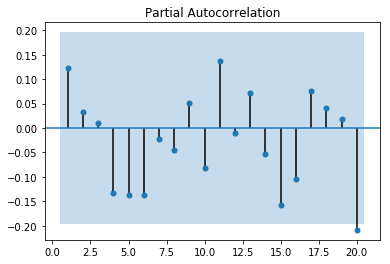

In [17]:
pacfplot = plot_pacf(whitenoise, alpha = .05, zero = False)

### Check Roots - Invertibility & Stationarity

There are rules to what parameters are to ensure stationarity. If we have a stationary series, the expectation/mean of y_t and y_t-1 should both be equal to mu i.e. the same. You thus, get mu = phi_0 (constant) + phi_1 * mu. Rearranging this gives us mu = (phi_0)/(1 - phi_1). Because mu must be finite, phi_1 cannot be equal to 1, as this indicates that the mean would approach infinity. 

In [0]:
ARmodel.params[0]/(1 - ARmodel.params[1])
print("Unconditional mean: ")
print("Unconditional variance: ")

Unconditional mean: 
Unconditional variance: 


To compute the unconditional variance, we start from mu = phi_0 + phi_1 * mu. We subtract this from y_t = phi_0 + phi_1 * y_t-1 + u_t. So we get y_t - mu = phi_1(y_t-1 - mu) + u_t. i.e. Deviations from the mean. We then square both sides to get: (y_t-1 - mu)^2 = phi_1^2(y_t-1 - mu)^2 + u_t^2 + 2*phi_1*(y_t-1 - mu)*u_t. Taking the unconditional expectation. The expression simplifies as u_t and y_t-1 - mu are independent. Thus we have E[(y_t - mu)^2] = phi_i^2*E[(y_t-1 - mu)^2] + E[u_t^2]. By definition E[u_t^2] the error variance is sigma_u^2. We expect that the unconditional variance is stationary so that E[(y_t - mu)^2] is the same as E[(y_t-1 - mu)^2], equal to say gamma_0. Thus, we get the expression: gamma_0 = phi_1^2*gamma_0 + sigma_u^2. Rearranging give us gamma_0 = sigma_u^2/(1 - phi_1^2). For it to be stationary, it must be finite, which is only the case if phi_1 is smaller than 1. 

It is important to be able to derive the unconditional mean, variance and covariances for AR(1) models and AR(2) models and AR(p) models.

### Check Residuals Are White Noise

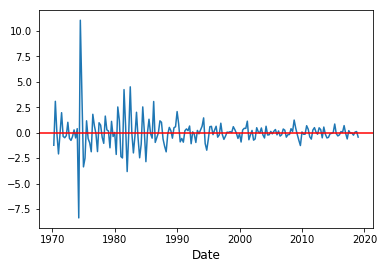

In [0]:
plt.plot(series['Date'][3:], output['Residual'])
plt.axhline(y = output['Residual'].mean(), color = 'r', linestyle = '-')
graph = plt.xlabel('Date', fontsize=12)

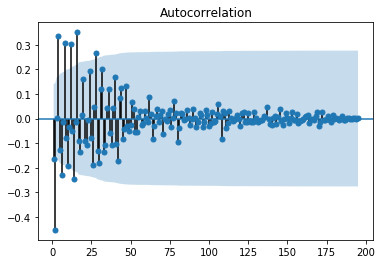

In [0]:
acfplot = plot_acf(output['Residual'], alpha = .05, zero = False)

### 3. Estimating AR(p) Model

We estimate the parameters of our models using **least squares (OLS)** estimator.

In [0]:
AR_lag = 1
variable = unemployment['URATE']

In [19]:
import statsmodels.api as sm
X = np.empty([np.count_nonzero(~np.isnan(variable)) - AR_lag,0])
for i in reversed(range(0,AR_lag + 1)):
    if i == AR_lag:
        Y = variable[pd.Series.first_valid_index(variable)+i:]
        Y = Y.values
    else:
        X1 = variable[pd.Series.first_valid_index(variable)+i:i-AR_lag]
        X = np.column_stack([X,X1])
X = sm.add_constant(X, prepend = True)
ARmodel = sm.OLS(Y, X).fit()
ARmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     8966.
Date:                Fri, 04 Oct 2019   Prob (F-statistic):          1.34e-165
Time:                        04:27:13   Log-Likelihood:                -52.307
No. Observations:                 198   AIC:                             108.6
Df Residuals:                     196   BIC:                             115.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1467      0.068      2.151      0.033       0.012       0.281
x1             0.9791      0.010     94.687      0.000       0.959       1.000
==============================================================================
Omnibus:                       79.857   Durbin-Watson:                   0.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.895
Skew:                           1.626   Prob(JB):                     3.72e-62
Kurtosis:                       7.869   Cond. No.                         20.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Estimated AR(1) model is:
$URATE_t = 0.1467 + 0.9791 URATE_{t-1} + \hat u_t$

i.e. $\phi_0 = 0.1467, \phi_1 - 0.9791$

Note: Different AIC and BIC/SIC values are different to Eviews. 


The estimated AR(2) model:

$URATE_t = 0.1365 + 1.4869 URATE_{t-1} + -0.5075 URATE_{t-2} + \hat u_t$

$\hat u_t$ represents the OLS residuals i.e. $URATE_t - \hat {URATE_t}$

Also note that our original series has 199 observations but because we regress against its lags (198 observations), our regression is done with 198 observations. The greater the AR order, the more observations lost. 

We can check if the coefficients are statistically significant based on the p-value (< 0.05) or t-statistic (> 1.96).

### 4. AR Model Properties - Unconditional Mean

From an AR model, we should know how to derive the inferred unconditional mean, variance and autocovariance. Understand the assumptions made and used.

e.g. Consider the AR(1) model:

$y_t = \phi_0 + \phi_1 y_{t-1} +u_t$

Unconditional mean:
1.   Obtain $E(y_t)$

$E(y_t) = \phi_0 + \phi_1 E(y_{t-1}) + E(u_t)$

2.   Use property that $E(u_t) = 0$

$E(y_t) = \phi_0 + \phi_1 E(y_{t-1})$

3. Stationary assumption implies $E(y_t) = E(y_{t-k} = \mu$)

$\mu = \phi_0 + \phi_1 \mu$

4. Solve for unconditional mean $\mu$

$\mu = \frac{\phi_0}{1-\phi_1}$

5. Note that stationary assumption implies $\phi_1 < 1$, because if $\phi_1 = 1$, mean would approach infinity (i.e. no longer finite). Note an unit root is where $\phi_1 = 1$.




### 5. Unconditional Variance for AR(1) Model

e.g. Consider the AR(1) model:

$y_t = \phi_0 + \phi_1 y_{t-1} +u_t$

1.   Obtain its 'mean' form (assuming stationarity and white noise errors)

$\mu = \phi_0 + \phi_1 \mu$

2. Obtain the deviations from the mean by subtracting the second equation:

$y_t - \mu = \phi_1 (y_{t-1} - \mu) +u_t$

3. Take the square of both sides:

$(y_t - \mu)^2 = \phi^2_1 (y_{t-1} - \mu)^2 +u^2_t + 2\phi_1(y_{t-1} - \mu)u_t$

4. Take the expectation, this gives the unconditional variance:

$E((y_t - \mu)^2) = \phi^2_1 E((y_{t-1} - \mu)^2) +E(u^2_t) + 2\phi_1E((y_{t-1} - \mu)u_t)$

5. We know that $(y_{t-1} - \mu)$ and $u_t$ are independent, which implies $E((y_{t-1} - \mu)u_t) = 0$

$E((y_t - \mu)^2) = \phi^2_1 E((y_{t-1} - \mu)^2) +E(u^2_t)$

6. By definition $E(u^2_t)$ is the error variance i.e. $E(u^2_t) = \sigma^2_u$

$E((y_t - \mu)^2) = \phi^2_1 E((y_{t-1} - \mu)^2) + \sigma^2_u$

7. Impose stationary in the variance condition:

$\gamma_0 = \phi^2_1 \gamma_0 + \sigma^2_u$

8. Solve for the unconditional variance:

$\gamma_0 = \frac{\sigma^2_u}{1-\phi^2_1}$

Note: the unconditional variance would not exist if $\phi_1 = 1$, otherwise the variance would be infinite. It also cannot be greater than 1 because variance by definition is non-negative.



### 6. Unconditional First Order Autocovariance (and $p$th Order Autocovariance) for AR(1) Model

e.g. Consider the AR(1) model:

$y_t = \phi_0 + \phi_1 y_{t-1} +u_t$

1. We define first order autocovariance as:

$\gamma_1 = E((y_t - \mu)(y_{t-1} - \mu))$

2. Obtain 'mean deviation' form (assuming stationarity and white noise errors):

$\mu = \phi_0 + \phi_1 \mu$

$y_t - \mu = \phi_1 (y_{t-1} - \mu) +u_t$

3. Don't take the square of both sides, now multiply both sides by $(y_{t-1} - \mu)$:

$(y_t - \mu)(y_{t-1}-\mu) = \phi_1 (y_{t-1} - \mu)^2 +u_t(y_{t-1}-\mu)$

4. Take the expectation, this gives the unconditional first order autocovariance:

$E((y_t - \mu)(y_{t-1}-\mu)) = \phi_1 E((y_{t-1} - \mu)^2) +E(u_t(y_{t-1}-\mu))$

5. We know that $(y_{t-1} - \mu)$ and $u_t$ are independent, which implies $E((y_{t-1} - \mu)u_t) = 0$

$E((y_t - \mu)(y_{t-1}-\mu)) = \phi_1 E((y_{t-1} - \mu)^2)$

6. By definition:

$\gamma_1 = \phi_1 \gamma_0)$

7. Input the unconditonal variance:

$\gamma_1 = \phi_1 \frac{\sigma^2_u}{1-\phi^2_1}$

For second order autocovariance:

$\gamma_2 = E((y_t - \mu)(y_{t-2} - \mu))$

We show that for the AR(1) model:

$\gamma_2 = \phi^2_1 \gamma_0$

For $p$th order autocovariance:

$\gamma_p = E((y_t - \mu)(y_{t-p} - \mu))$

$\gamma_p = \phi^p_1 \gamma_0$

### 7. First Order Autocorrelation and $p$th Order Autocorrelation for AR(1) Model

Autocorrelation is just standardised autocovariance, where we divide by the variance.

We know the variance of $y_t$ is $\gamma_0$.

Hence, first order autocorrelation (for AR(1) model) is:

$\rho_1 = \frac{\gamma_1}{\gamma_0} = \phi_1$

For $p$th order autocorrelation:
$\rho_p = \frac{\gamma_p}{\gamma_0} = \phi^p_1$

This tells us that the ACF decays exponentially if $|\phi_1|<1$, which is a condition imposed by stationarity.




### 8. Unconditional Mean, Variance, Autocovariance, Autocorrelation for AR(2) Model

More involved, not that simple.

Consider the AR(2) Model:

$y_t = \phi_0 + \phi_1 y_{t-1} + \phi_2 y_{t-2} + u_t$

Take expectation, impose zero error mean, impose mean stationarity (same at any time), gives us the mean:

$E(y_t) = \phi_0 + \phi_1 E(y_{t-1}) + \phi_2 E(y_{t-2})$

$\mu = \phi_0 + \phi_1 \mu + \phi_2 \mu$

$\mu = \frac{\phi_0}{1-\phi_1 - \phi_2}$

Note: unconditional mean doesn't exist if $\phi_1 + \phi_2 = 1$, otherwise mean would be infinite.

Subtract AR(2) model against its mean deviation form:

$y_t - \mu = \phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t$

Multiply both sides by $(y_t - \mu)$, take expectations and use definitions of autocovariances:

$(y_t - \mu)^2 = \phi_1(y_t - \mu)(y_{t-1} - \mu) + \phi_2 (y_t - \mu)(y_{t-2} - \mu) + (y_t - \mu)u_t$

$E((y_t - \mu)^2) = \phi_1E((y_t - \mu)(y_{t-1} - \mu)) + \phi_2 E((y_t - \mu)(y_{t-2} - \mu)) + E((y_t - \mu)u_t)$

$\gamma_0 = \phi_1 \gamma_1 + \phi_2 \gamma_2 + E((y_t - \mu)u_t)$

Dealing with the $E((y_t - \mu)u_t)$ term, we know that $y_t -\mu$ is:

$y_t - \mu = \phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t$

Multiply it by $u_t$ and then take the expectation:

$E(u_t(y_t - \mu)) = E(u_t(\phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t))$

$E(u_t(y_t - \mu)) = \phi_1 E(u_t(y_{t-1} - \mu)) + \phi_2 E(u_t(y_{t-2} - \mu)) + E(u^2_t)$

We know that the terms are independent and the definition of the error variance. this gives us the unconditional variance:

$E(u_t(y_t - \mu)) = \sigma^2_u$

$\gamma_0 = \phi_1 \gamma_1 + \phi_2 \gamma_2 + \sigma^2_u$

To get the first order autocovariance, we use the mean deviation form:

$y_t - \mu = \phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t$

Multiply both sides by $(y_{t-1} - \mu)$:

$(y_t - \mu)(y_{t-1} - \mu) = \phi_1(y_{t-1} - \mu)(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu)(y_{t-1} - \mu) + u_t(y_{t-1} - \mu)$

Take unconditional expectation:

$E((y_t - \mu)(y_{t-1} - \mu)) = \phi_1 E((y_{t-1} - \mu)(y_{t-1} - \mu)) + \phi_2 E((y_{t-2} - \mu)(y_{t-1} - \mu)) + E(u_t(y_{t-1} - \mu))$

$\gamma_1 = \phi_1 \gamma_0 + \phi_2 \gamma_1$

$\gamma_1 = \frac{\phi_1}{1-\phi_2}\gamma_0$

To get the second order autocovariance, use mean deviation form, multiply by $(y_{t-2} - \mu)$ and take expectation:

$y_t - \mu = \phi_1(y_{t-1} - \mu) + \phi_2 (y_{t-2} - \mu) + u_t$

$(y_t - \mu)(y_{t-2} - \mu) = \phi_1(y_{t-1} - \mu)(y_{t-2} - \mu) + \phi_2 (y_{t-2} - \mu)(y_{t-2} - \mu) + u_t(y_{t-2} - \mu)$

$\gamma_2 = \phi_1 \gamma_1 + \phi_2 \gamma_0$

Substitute in the $\gamma_1$ equation:

$\gamma_2 = \frac{\phi^2_1}{1-\phi_2}\gamma_0 + \phi_2 \gamma_0 = (\frac{\phi^2_1}{1-\phi_2} + \phi_2)\gamma_0$

We can finally solve for variance because we now have the two autocovariance terms in terms of coefficients and variance terms:

$\gamma_0 = \phi_1 \gamma_1 + \phi_2 \gamma_2 + \sigma^2_u$

$\gamma_0 = \frac{\phi^2_1}{1-\phi_2}\gamma_0 +  (\frac{\phi_2 \phi^2_1}{1-\phi_2} + \phi^2_2)\gamma_0 + \sigma^2_u$

$\gamma_0 = \frac{(1-\phi_2)\sigma^2_u}{(1+\phi_2)((1-\phi_2)^2 - \phi^2_1)}$


### 9. Ex-Ante Point Forecasting 

We have the OLS estimates for our model parameters. Now to forecast $y_{t+1}$, our model is thus $\phi_0 + \phi_1 y_t + u_{t+1}$. 

We have today's value $y_t$, we don't know the parameters. 

But we can replace the unknown parameters using our OLS estimates $\hat \phi_0$ and $\hat \phi_1$. 

The futue value of the error term is replaced with its unconditional mean, which is 0. 

Thus our forecast at $t+1$ is thus $\hat y_{t+1} = \hat \phi_0 + \hat \phi_1 y_t$.

In [20]:
num_forecasts = 7
starting_values = Y[-AR_lag:]
for i in range(0, num_forecasts):
    forecast_1period = ARmodel.params[0]
    for i in range(0, AR_lag):
        forecast_1period = forecast_1period + ARmodel.params[i+1]*starting_values[-1-i]
    starting_values = np.append(starting_values,forecast_1period)
print(starting_values)

[5.019 5.061 5.102 5.142 5.181 5.22  5.258 5.295]


The unemployment rate is predicted to increase continually over the forecast period, peaking at 5.29% in 2020Q4.

The property of our model is that forecasts will converge to the long-run mean given stationarity. Above we have computed that the long-run mean is 7.02ish i.e. Natural rate of unemployment is 7.02%, which our forecasts will approach.

The long-run estimated AR(1) mean is:
$\frac{0.1467}{1-0.9791} = 7.0191$

###10. Ex-Ante Interval Forecasts

We can also think about interval forecasts i.e. a range of future values in order to reflect uncertainties. There are 2 types of uncertainties in our forecasting model: 
1.   Parameter uncertainty (OLS estimate $\hat \beta$ vs. the population parameter $\beta$) 
2.   Disturbance/Error uncertainty (as $\sigma^2_u > 0$).

###11. Ex-Post Forecasts

Ex-Ante Forecasting is where all of the information is used to estimate the model up to the most recent observation. 

Ex-Post forecasting is an alternative method where you use a restricted sample and generate forecasts over a horizon, the benefit where you can compare your results/performance with the actual data.

In [21]:
output = pd.DataFrame()
output['AR(1) Fitted Y'] = ARmodel.fittedvalues
output['Actual'] = (variable[pd.Series.first_valid_index(variable)+1:]).values
output['Residual'] = output['Actual'] - output['AR(1) Fitted Y']
output.head()

,AR(1) Fitted Y,Actual,Residual
0,1.8112,1.9000,0.0888
1,2.0071,1.6000,-0.4071
2,1.7133,1.7000,-0.0133
3,1.8112,1.7000,-0.1112
4,1.8112,1.6000,-0.2112


In [22]:
expected = output['Actual']
predictions = output['AR(1) Fitted Y']
#Mean Absolute Error
mae = mean_absolute_error(expected, predictions)
#Mean Square Error
mse = mean_squared_error(expected, predictions)
#Root Mean Squared Error
rmse = sqrt(mse)
print('Mean Absolute Error: %f' % mae)
print('Mean Square Error: %f' % mse)
print('Root Mean Square Error: %f' % rmse)

Mean Absolute Error: 0.221709
Mean Square Error: 0.099308
Root Mean Square Error: 0.315132


###Nonlinear Time Series Extensions

AR Models are linear.

We can have non-linear models e.g. nonlinear AR(1) models:

$y_t = \phi_0 + \phi_1 y_{t-1} + \beta y^2_{t-1} + u_t$

Another nonlinear AR(1) ANN model is:
$y_t = \phi_0 + \phi_1 y_{t-1} + \beta \frac{1}{1 + \exp(-(\delta_0+\delta_1y_{t-1}))} + u_t$

This is known as a hidden-layer, feed-forward artificial neural network where the non-linear term is called a 'squasher' with a hidden layer and a neurode.

Estimation of such models involves computing the residual sum of squares for each parameter estimates, known as the 'fitness function'. This is done iteratively and used to update the parameter estimates to reduces sum of squares - this process is known as ML. Estimation of ANN models are numerically difficult.

Other nonlinear models include:

1.   Self-exciting threshold autoregressive models (SETAR)
2.   Smooth Transitional Autoregressive models (STAR)
3.   Genetic algorithms
4.   Chaos theory - produces 'random' looking behaviour which is actually deterministic (which implies predictability) - does that mean stock price movmeents that appear random could reflect a nonlinear deterministic process? If so, the difficulty is finding the parameters!
5.   Artifical neural networks (ANN) and machine learning (ML)



### Augmented Dickey Fuller (ADF) / Unit Root Test

Null: Time series can be represented by a unit root i.e. not-stationary, 
Alternative: Time series cannot be rejected by a unit root, 
P-value below 0.05 suggests we reject the null at the 5% level. This tests for stochastic non-stationarity. This is computed as the change in the variable regressed against a constant, and it lagged values and lagged changes.

In [0]:
X = variable.values[pd.Series.first_valid_index(variable):]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Lags Used: %f' % result[2])
print('Observations Used %f' % result[3])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
if (result[1]<0.05):
    print("Reject null at 5% level? YES")
else:
    print("Reject null at 5% level? NO")

ADF Statistic: -7.820016
p-value: 0.000000
Lags Used: 15.000000
Observations Used 181.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Reject null at 5% level? YES


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

Null: time series is stationarity around a deterministic trend against the alternative of a unit root. Option: c = stationarity around a constant, ct = stationarity around a trend. P-value below 0.05 suggests we reject the null at the 5% level.

In [0]:
kpssresults = kpss(variable[pd.Series.first_valid_index(variable):],'c')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [0]:
kpss_pvalue = kpssresults[1]
print("P-value 5% level: {:.4f}".format(kpss_pvalue))

P-value 5% level: 0.1000


###Unanswered Questions

1.   What is the difference in the intuition and usage of PACF and ACF?
2.   Why is stationarity important?
3.   Stationary series should have rapidly decaying ACFs. What is considered rapidly decaying?
4.   What is the main purpose of the ACF and PACF? Is it any good at detecting stationarity? Is it mainly to identify what AR, MA or ARMA model is appropriate model to use to predict our variable of interest? Are there any other purposes?
5.   Python packages for AR seem to compute using maximum likelihood. Would there be any practical problems with using this method?
6.   We know that $(y_{t-1} - \mu)$ and $u_t$ are independent?

